In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os


In [2]:
import joblib
import pandas as pd

data_ki = joblib.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/dataset/ki/ki_with_features.joblib')
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,log10ki_mean,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [3]:
data_ki.rename(columns={'log10ki_mean':'label'},inplace=True)
data_ki.head()

,Sequence,sequence_source,uniprot,Smiles,value,ec,log10_value,label,metabolite_features,protein_features
0,MHTKGPTPQQHDGSALRIGIVHARWNETIIEPLLAGTKAKLLACGV...,uniprot_search,A0A6P8BCR9,O=c1n(C[C@H](O)[C@H](O)[C@H](O)CO)c2nc(O)nc(O)...,0.000002,2.5.1.78,-5.698970,-5.698970,"[0.17249086, -0.23665705, -0.11737049, -0.0940...","[0.026722027, -0.06119407, 0.041440543, -0.109..."
1,MASPDWGYDDKNGPEQWSKLYPIANGNNQSPVDIKTSETKHDTSLK...,brenda,P00915,CN1CCN(C(=O)c2ccc(S(N)(=O)=O)cc2)[C@@H](Cc2ccc...,0.000707,4.2.1.1,-3.150581,-3.150581,"[0.4240491, 0.28231123, 0.2642891, -0.7667821,...","[-0.029181704, -0.12635791, 0.10866662, 0.0339..."
2,MLDDIRGFMNTFSETMFMDVINYSLTRDRYDSVFLQRQNYRDLGQL...,brenda,Q9HLD0,C[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O...,0.002990,3.2.1.20,-2.524329,-2.524329,"[0.50005734, 0.3923428, 0.064121775, -0.635894...","[0.02874529, -0.17312695, -0.0026887748, 0.035..."
3,MKLMENIFDLAKANKKKIVLAEGEEERNIRASEEIIKDGIADIILV...,uniprot_search,A0A1L5F6Z9,CCN=C(O)CCN=C(O)[C@H](O)C(C)(C)COP(=O)(O)OP(=O...,0.020000,2.3.1.8,-1.698970,-1.698970,"[0.28353548, 0.018489605, -0.5459905, -0.34693...","[-0.06555556, 0.04763434, 0.031432115, 0.17143..."
4,MAKRIVEPFRIKMVEKIRVPSREEREAALKEAGYNPFLLPSSAVYI...,sabio,P28796,CC(N)C(=O)O,24.500000,4.1.99.1,1.389166,1.419631,"[0.051456872, 0.35619217, 0.10593035, -1.04098...","[0.049294557, -0.043596543, 0.0546125, 0.35600..."


In [4]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [5]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data_ki, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F

# Define Transformer for Regression
# https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
class TransformerRegressor(nn.Module):
    def __init__(self, mol_input_dim, protein_input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()

        # Linear projection to embedding space
        self.mol_proj = nn.Linear(mol_input_dim, d_model)
        self.protein_proj = nn.Linear(protein_input_dim, d_model)

        # Positional encoding (learnable)
        self.pos_embedding = nn.Parameter(torch.randn(2, d_model))  # 2 positions: [mol, protein]

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, mol_input, protein_input):
        # Project input to embedding space
        mol_embed = self.mol_proj(mol_input).unsqueeze(1)       # shape: (B, 1, d_model)
        protein_embed = self.protein_proj(protein_input).unsqueeze(1)  # shape: (B, 1, d_model)

        # Concatenate [mol, protein] tokens → sequence length = 2
        x = torch.cat([mol_embed, protein_embed], dim=1)  # shape: (B, 2, d_model)

        # Add learnable positional encoding
        x = x + self.pos_embedding.unsqueeze(0)  # broadcast (1, 2, d_model)

        # Pass through Transformer encoder
        encoded = self.transformer(x)  # shape: (B, 2, d_model)

        # Flatten both tokens
        flattened = encoded.view(encoded.size(0), -1)  # shape: (B, 2 * d_model)

        # Regression
        out = self.regressor(flattened)
        return out.view(-1)

In [7]:
# Check CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr


train_history = pd.DataFrame(columns=[  'epoch',
    'Train Loss', 'Train MSE', 'Train MAE', 'Train RMSE', 'Train R2', 'Train Pearson', 'Train Median_AE', 'Train Explained_VAR'
    'Val Loss', 'Val MSE', 'Val MAE', 'Val RMSE', 'Val R2', 'Val Pearson', 'Val Median_AE', 'Val Explained_VAR'])
# Verify feature dimensions
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = TransformerRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

# Training and Validation Loop
for epoch in range(2000):
    model.train()
    total_loss = 0.0
    val_total_loss = 0.0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(mol_features, protein_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for metrics
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    train_mse = ((torch.tensor(train_predictions) - torch.tensor(train_labels))**2).mean().item()
    train_mae = torch.abs(torch.tensor(train_predictions) - torch.tensor(train_labels)).mean().item()
    train_rmse = torch.sqrt((torch.tensor(train_predictions) - torch.tensor(train_labels)) ** 2).mean().item()
    train_r2 = r2_score(np.array(train_labels), np.array(train_predictions))
    train_pearson_corr, _ = pearsonr(np.array(train_labels), np.array(train_predictions))
    train_median_ae = median_absolute_error(np.array(train_labels), np.array(train_predictions))
    train_explained_var = explained_variance_score(np.array(train_labels), np.array(train_predictions))



    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Train Loss: {total_loss / len(train_loader):.4f}, Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}")

    # Validation
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            mol_features = batch['metabolite_features'].to(device)
            protein_features = batch['protein_features'].to(device)
            labels = batch['label'].to(device)

            outputs = model(mol_features, protein_features)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_mse = ((torch.tensor(val_predictions) - torch.tensor(val_labels))**2).mean().item()
    val_mae = torch.abs(torch.tensor(val_predictions) - torch.tensor(val_labels)).mean().item()
    val_rmse = torch.sqrt((torch.tensor(val_predictions) - torch.tensor(val_labels)) ** 2).mean().item()
    val_r2 = r2_score(np.array(val_labels), np.array(val_predictions))
    val_pearson_corr, _ = pearsonr(np.array(val_labels), np.array(val_predictions))
    val_median_ae = median_absolute_error(np.array(val_labels), np.array(val_predictions))
    val_explained_var = explained_variance_score(np.array(val_labels), np.array(val_predictions))

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation MSE: {val_mse:.4f}, Validation MAE: {val_mae:.4f}")

    # Save metrics to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train RMSE': train_rmse, 'Train R2': train_r2, 'Train Pearson': train_pearson_corr, 'Train Median_AE': train_median_ae, 'Train Explained_VAR': train_explained_var, 
               'Val Loss': val_total_loss / len(val_loader), 'Val MSE': val_mse, 'Val MAE': val_mae, 'Val RMSE': val_rmse, 'Val R2': val_r2, 'Val Pearson': val_pearson_corr, 'Val Median_AE': val_median_ae, 'Val Explained_VAR': val_explained_var}
    train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)



Training Epoch 1: 100%|██████████| 261/261 [00:04<00:00, 59.92it/s]
/var/folders/yz/c1z6m9_d5d3f80sywjc3rqsc0000gn/T/ipykernel_17858/1634219118.py:92: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_history = pd.concat([train_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 0 - Train Loss: 3.0208, Train MSE: 3.0211, Train MAE: 1.3789
Epoch 0 - Validation Loss: 2.6287, Validation MSE: 2.6295, Validation MAE: 1.2910


Training Epoch 11: 100%|██████████| 261/261 [00:03<00:00, 66.21it/s]


Epoch 10 - Train Loss: 2.0619, Train MSE: 2.0621, Train MAE: 1.1258
Epoch 10 - Validation Loss: 2.3966, Validation MSE: 2.3972, Validation MAE: 1.1956


Training Epoch 21: 100%|██████████| 261/261 [00:04<00:00, 58.07it/s]


Epoch 20 - Train Loss: 1.5745, Train MSE: 1.5746, Train MAE: 0.9762
Epoch 20 - Validation Loss: 2.1352, Validation MSE: 2.1363, Validation MAE: 1.1264


Training Epoch 31: 100%|██████████| 261/261 [00:04<00:00, 56.93it/s]


Epoch 30 - Train Loss: 1.1732, Train MSE: 1.1732, Train MAE: 0.8390
Epoch 30 - Validation Loss: 1.9161, Validation MSE: 1.9176, Validation MAE: 1.0529


Training Epoch 41: 100%|██████████| 261/261 [00:04<00:00, 55.95it/s]


Epoch 40 - Train Loss: 0.9027, Train MSE: 0.9028, Train MAE: 0.7316
Epoch 40 - Validation Loss: 1.9042, Validation MSE: 1.9056, Validation MAE: 1.0368


Training Epoch 51: 100%|██████████| 261/261 [00:04<00:00, 57.42it/s]


Epoch 50 - Train Loss: 0.7283, Train MSE: 0.7283, Train MAE: 0.6568
Epoch 50 - Validation Loss: 1.8903, Validation MSE: 1.8922, Validation MAE: 1.0226


Training Epoch 61: 100%|██████████| 261/261 [00:04<00:00, 59.04it/s]


Epoch 60 - Train Loss: 0.6083, Train MSE: 0.6081, Train MAE: 0.5977
Epoch 60 - Validation Loss: 1.8698, Validation MSE: 1.8713, Validation MAE: 1.0181


Training Epoch 71: 100%|██████████| 261/261 [00:04<00:00, 52.89it/s]


Epoch 70 - Train Loss: 0.5030, Train MSE: 0.5029, Train MAE: 0.5425
Epoch 70 - Validation Loss: 1.9110, Validation MSE: 1.9128, Validation MAE: 1.0155


Training Epoch 81: 100%|██████████| 261/261 [16:03<00:00,  3.69s/it] 


Epoch 80 - Train Loss: 0.4301, Train MSE: 0.4301, Train MAE: 0.5031
Epoch 80 - Validation Loss: 1.9192, Validation MSE: 1.9206, Validation MAE: 1.0239


Training Epoch 91: 100%|██████████| 261/261 [00:07<00:00, 34.29it/s]


Epoch 90 - Train Loss: 0.3788, Train MSE: 0.3788, Train MAE: 0.4703
Epoch 90 - Validation Loss: 1.8833, Validation MSE: 1.8849, Validation MAE: 1.0066


Training Epoch 101: 100%|██████████| 261/261 [00:04<00:00, 52.42it/s]


Epoch 100 - Train Loss: 0.3370, Train MSE: 0.3369, Train MAE: 0.4413
Epoch 100 - Validation Loss: 1.9294, Validation MSE: 1.9311, Validation MAE: 1.0091


Training Epoch 111: 100%|██████████| 261/261 [00:04<00:00, 55.25it/s]


Epoch 110 - Train Loss: 0.3027, Train MSE: 0.3027, Train MAE: 0.4214
Epoch 110 - Validation Loss: 1.8242, Validation MSE: 1.8253, Validation MAE: 0.9989


Training Epoch 121: 100%|██████████| 261/261 [00:04<00:00, 52.48it/s]


Epoch 120 - Train Loss: 0.2863, Train MSE: 0.2863, Train MAE: 0.4044
Epoch 120 - Validation Loss: 1.8452, Validation MSE: 1.8469, Validation MAE: 0.9874


Training Epoch 131: 100%|██████████| 261/261 [00:05<00:00, 51.44it/s]


Epoch 130 - Train Loss: 0.2584, Train MSE: 0.2584, Train MAE: 0.3845
Epoch 130 - Validation Loss: 1.8201, Validation MSE: 1.8217, Validation MAE: 0.9742


Training Epoch 141: 100%|██████████| 261/261 [00:04<00:00, 53.21it/s]


Epoch 140 - Train Loss: 0.2519, Train MSE: 0.2519, Train MAE: 0.3752
Epoch 140 - Validation Loss: 1.8017, Validation MSE: 1.8032, Validation MAE: 0.9779


Training Epoch 151: 100%|██████████| 261/261 [00:04<00:00, 55.46it/s]


Epoch 150 - Train Loss: 0.2180, Train MSE: 0.2180, Train MAE: 0.3499
Epoch 150 - Validation Loss: 1.7989, Validation MSE: 1.8002, Validation MAE: 0.9693


Training Epoch 161: 100%|██████████| 261/261 [00:04<00:00, 53.91it/s]


Epoch 160 - Train Loss: 0.2008, Train MSE: 0.2008, Train MAE: 0.3387
Epoch 160 - Validation Loss: 1.8355, Validation MSE: 1.8370, Validation MAE: 0.9849


Training Epoch 171: 100%|██████████| 261/261 [00:04<00:00, 52.67it/s]


Epoch 170 - Train Loss: 0.1949, Train MSE: 0.1949, Train MAE: 0.3310
Epoch 170 - Validation Loss: 1.7762, Validation MSE: 1.7777, Validation MAE: 0.9751


Training Epoch 181: 100%|██████████| 261/261 [00:05<00:00, 43.61it/s]


Epoch 180 - Train Loss: 0.1756, Train MSE: 0.1756, Train MAE: 0.3149
Epoch 180 - Validation Loss: 1.7685, Validation MSE: 1.7701, Validation MAE: 0.9625


Training Epoch 191: 100%|██████████| 261/261 [00:06<00:00, 41.04it/s]


Epoch 190 - Train Loss: 0.1753, Train MSE: 0.1753, Train MAE: 0.3131
Epoch 190 - Validation Loss: 1.8108, Validation MSE: 1.8123, Validation MAE: 0.9738


Training Epoch 201: 100%|██████████| 261/261 [00:07<00:00, 35.71it/s]


Epoch 200 - Train Loss: 0.1620, Train MSE: 0.1620, Train MAE: 0.3005
Epoch 200 - Validation Loss: 1.7312, Validation MSE: 1.7325, Validation MAE: 0.9594


Training Epoch 211: 100%|██████████| 261/261 [00:09<00:00, 26.15it/s]


Epoch 210 - Train Loss: 0.1571, Train MSE: 0.1571, Train MAE: 0.2941
Epoch 210 - Validation Loss: 1.7774, Validation MSE: 1.7788, Validation MAE: 0.9572


Training Epoch 221: 100%|██████████| 261/261 [00:07<00:00, 32.69it/s]


Epoch 220 - Train Loss: 0.1403, Train MSE: 0.1403, Train MAE: 0.2821
Epoch 220 - Validation Loss: 1.7779, Validation MSE: 1.7792, Validation MAE: 0.9651


Training Epoch 231: 100%|██████████| 261/261 [00:11<00:00, 22.53it/s]


Epoch 230 - Train Loss: 0.1476, Train MSE: 0.1476, Train MAE: 0.2835
Epoch 230 - Validation Loss: 1.7627, Validation MSE: 1.7640, Validation MAE: 0.9533


Training Epoch 241: 100%|██████████| 261/261 [16:50<00:00,  3.87s/it]  


Epoch 240 - Train Loss: 0.1348, Train MSE: 0.1347, Train MAE: 0.2731
Epoch 240 - Validation Loss: 1.7714, Validation MSE: 1.7729, Validation MAE: 0.9627


Training Epoch 251: 100%|██████████| 261/261 [00:07<00:00, 36.68it/s]


Epoch 250 - Train Loss: 0.1286, Train MSE: 0.1286, Train MAE: 0.2662
Epoch 250 - Validation Loss: 1.7403, Validation MSE: 1.7415, Validation MAE: 0.9493


Training Epoch 261: 100%|██████████| 261/261 [00:06<00:00, 38.45it/s]


Epoch 260 - Train Loss: 0.1294, Train MSE: 0.1294, Train MAE: 0.2639
Epoch 260 - Validation Loss: 1.7179, Validation MSE: 1.7195, Validation MAE: 0.9396


Training Epoch 271: 100%|██████████| 261/261 [00:06<00:00, 37.93it/s]


Epoch 270 - Train Loss: 0.1268, Train MSE: 0.1268, Train MAE: 0.2627
Epoch 270 - Validation Loss: 1.7519, Validation MSE: 1.7535, Validation MAE: 0.9521


Training Epoch 281: 100%|██████████| 261/261 [00:06<00:00, 38.55it/s]


Epoch 280 - Train Loss: 0.1180, Train MSE: 0.1180, Train MAE: 0.2530
Epoch 280 - Validation Loss: 1.7751, Validation MSE: 1.7766, Validation MAE: 0.9481


Training Epoch 291: 100%|██████████| 261/261 [00:07<00:00, 35.97it/s]


Epoch 290 - Train Loss: 0.1254, Train MSE: 0.1254, Train MAE: 0.2598
Epoch 290 - Validation Loss: 1.7420, Validation MSE: 1.7436, Validation MAE: 0.9408


Training Epoch 301: 100%|██████████| 261/261 [00:07<00:00, 36.76it/s]


Epoch 300 - Train Loss: 0.1152, Train MSE: 0.1152, Train MAE: 0.2530
Epoch 300 - Validation Loss: 1.7263, Validation MSE: 1.7280, Validation MAE: 0.9446


Training Epoch 311: 100%|██████████| 261/261 [00:06<00:00, 37.88it/s]


Epoch 310 - Train Loss: 0.1139, Train MSE: 0.1138, Train MAE: 0.2478
Epoch 310 - Validation Loss: 1.7246, Validation MSE: 1.7261, Validation MAE: 0.9479


Training Epoch 321: 100%|██████████| 261/261 [00:06<00:00, 38.36it/s]


Epoch 320 - Train Loss: 0.1168, Train MSE: 0.1169, Train MAE: 0.2476
Epoch 320 - Validation Loss: 1.7255, Validation MSE: 1.7271, Validation MAE: 0.9502


Training Epoch 331: 100%|██████████| 261/261 [00:06<00:00, 39.56it/s]


Epoch 330 - Train Loss: 0.1117, Train MSE: 0.1117, Train MAE: 0.2433
Epoch 330 - Validation Loss: 1.6745, Validation MSE: 1.6762, Validation MAE: 0.9243


Training Epoch 341: 100%|██████████| 261/261 [00:06<00:00, 37.35it/s]


Epoch 340 - Train Loss: 0.1051, Train MSE: 0.1051, Train MAE: 0.2384
Epoch 340 - Validation Loss: 1.6993, Validation MSE: 1.7009, Validation MAE: 0.9359


Training Epoch 351: 100%|██████████| 261/261 [00:06<00:00, 39.35it/s]


Epoch 350 - Train Loss: 0.1108, Train MSE: 0.1108, Train MAE: 0.2408
Epoch 350 - Validation Loss: 1.7239, Validation MSE: 1.7256, Validation MAE: 0.9444


Training Epoch 361: 100%|██████████| 261/261 [00:06<00:00, 40.62it/s]


Epoch 360 - Train Loss: 0.1041, Train MSE: 0.1041, Train MAE: 0.2338
Epoch 360 - Validation Loss: 1.7047, Validation MSE: 1.7061, Validation MAE: 0.9380


Training Epoch 371: 100%|██████████| 261/261 [00:06<00:00, 38.48it/s]


Epoch 370 - Train Loss: 0.0966, Train MSE: 0.0966, Train MAE: 0.2263
Epoch 370 - Validation Loss: 1.7205, Validation MSE: 1.7222, Validation MAE: 0.9422


Training Epoch 381: 100%|██████████| 261/261 [00:06<00:00, 41.06it/s]


Epoch 380 - Train Loss: 0.1001, Train MSE: 0.1001, Train MAE: 0.2311
Epoch 380 - Validation Loss: 1.6839, Validation MSE: 1.6854, Validation MAE: 0.9304


Training Epoch 391: 100%|██████████| 261/261 [00:06<00:00, 39.21it/s]


Epoch 390 - Train Loss: 0.0937, Train MSE: 0.0937, Train MAE: 0.2208
Epoch 390 - Validation Loss: 1.7013, Validation MSE: 1.7030, Validation MAE: 0.9330


Training Epoch 401: 100%|██████████| 261/261 [00:06<00:00, 37.49it/s]


Epoch 400 - Train Loss: 0.0930, Train MSE: 0.0930, Train MAE: 0.2221
Epoch 400 - Validation Loss: 1.7040, Validation MSE: 1.7059, Validation MAE: 0.9327


Training Epoch 411: 100%|██████████| 261/261 [00:06<00:00, 38.69it/s]


Epoch 410 - Train Loss: 0.0931, Train MSE: 0.0931, Train MAE: 0.2195
Epoch 410 - Validation Loss: 1.7433, Validation MSE: 1.7450, Validation MAE: 0.9453


Training Epoch 421: 100%|██████████| 261/261 [00:06<00:00, 39.38it/s]


Epoch 420 - Train Loss: 0.0875, Train MSE: 0.0875, Train MAE: 0.2145
Epoch 420 - Validation Loss: 1.7043, Validation MSE: 1.7061, Validation MAE: 0.9375


Training Epoch 431: 100%|██████████| 261/261 [00:09<00:00, 27.70it/s]


Epoch 430 - Train Loss: 0.0904, Train MSE: 0.0904, Train MAE: 0.2191
Epoch 430 - Validation Loss: 1.7337, Validation MSE: 1.7356, Validation MAE: 0.9426


Training Epoch 441: 100%|██████████| 261/261 [00:07<00:00, 36.99it/s]


Epoch 440 - Train Loss: 0.0861, Train MSE: 0.0861, Train MAE: 0.2113
Epoch 440 - Validation Loss: 1.7317, Validation MSE: 1.7334, Validation MAE: 0.9452


Training Epoch 451: 100%|██████████| 261/261 [00:06<00:00, 37.59it/s]


Epoch 450 - Train Loss: 0.0960, Train MSE: 0.0960, Train MAE: 0.2196
Epoch 450 - Validation Loss: 1.7092, Validation MSE: 1.7110, Validation MAE: 0.9333


Training Epoch 461: 100%|██████████| 261/261 [00:06<00:00, 38.08it/s]


Epoch 460 - Train Loss: 0.0839, Train MSE: 0.0839, Train MAE: 0.2114
Epoch 460 - Validation Loss: 1.7078, Validation MSE: 1.7097, Validation MAE: 0.9310


Training Epoch 471: 100%|██████████| 261/261 [00:07<00:00, 37.27it/s]


Epoch 470 - Train Loss: 0.0829, Train MSE: 0.0829, Train MAE: 0.2072
Epoch 470 - Validation Loss: 1.7217, Validation MSE: 1.7235, Validation MAE: 0.9359


Training Epoch 481: 100%|██████████| 261/261 [00:07<00:00, 37.12it/s]


Epoch 480 - Train Loss: 0.0889, Train MSE: 0.0889, Train MAE: 0.2130
Epoch 480 - Validation Loss: 1.7067, Validation MSE: 1.7085, Validation MAE: 0.9329


Training Epoch 491: 100%|██████████| 261/261 [00:06<00:00, 38.87it/s]


Epoch 490 - Train Loss: 0.0809, Train MSE: 0.0809, Train MAE: 0.2046
Epoch 490 - Validation Loss: 1.7030, Validation MSE: 1.7046, Validation MAE: 0.9314


Training Epoch 501: 100%|██████████| 261/261 [00:06<00:00, 38.67it/s]


Epoch 500 - Train Loss: 0.0837, Train MSE: 0.0837, Train MAE: 0.2085
Epoch 500 - Validation Loss: 1.7063, Validation MSE: 1.7077, Validation MAE: 0.9371


Training Epoch 511: 100%|██████████| 261/261 [00:06<00:00, 37.71it/s]


Epoch 510 - Train Loss: 0.0782, Train MSE: 0.0782, Train MAE: 0.2007
Epoch 510 - Validation Loss: 1.6706, Validation MSE: 1.6720, Validation MAE: 0.9189


Training Epoch 521: 100%|██████████| 261/261 [00:07<00:00, 37.01it/s]


Epoch 520 - Train Loss: 0.0803, Train MSE: 0.0803, Train MAE: 0.2042
Epoch 520 - Validation Loss: 1.6973, Validation MSE: 1.6989, Validation MAE: 0.9315


Training Epoch 531: 100%|██████████| 261/261 [00:06<00:00, 38.02it/s]


Epoch 530 - Train Loss: 0.0791, Train MSE: 0.0791, Train MAE: 0.2011
Epoch 530 - Validation Loss: 1.7166, Validation MSE: 1.7185, Validation MAE: 0.9340


Training Epoch 541: 100%|██████████| 261/261 [00:06<00:00, 38.68it/s]


Epoch 540 - Train Loss: 0.0778, Train MSE: 0.0778, Train MAE: 0.2005
Epoch 540 - Validation Loss: 1.7093, Validation MSE: 1.7110, Validation MAE: 0.9349


Training Epoch 551: 100%|██████████| 261/261 [00:20<00:00, 12.74it/s]


Epoch 550 - Train Loss: 0.0732, Train MSE: 0.0732, Train MAE: 0.1940
Epoch 550 - Validation Loss: 1.6747, Validation MSE: 1.6765, Validation MAE: 0.9230


Training Epoch 561: 100%|██████████| 261/261 [00:07<00:00, 37.04it/s]


Epoch 560 - Train Loss: 0.0730, Train MSE: 0.0730, Train MAE: 0.1946
Epoch 560 - Validation Loss: 1.6842, Validation MSE: 1.6859, Validation MAE: 0.9268


Training Epoch 571: 100%|██████████| 261/261 [00:26<00:00,  9.99it/s]


Epoch 570 - Train Loss: 0.0715, Train MSE: 0.0714, Train MAE: 0.1928
Epoch 570 - Validation Loss: 1.7176, Validation MSE: 1.7193, Validation MAE: 0.9331


Training Epoch 581: 100%|██████████| 261/261 [00:10<00:00, 24.64it/s]


Epoch 580 - Train Loss: 0.0920, Train MSE: 0.0920, Train MAE: 0.2115
Epoch 580 - Validation Loss: 1.6599, Validation MSE: 1.6614, Validation MAE: 0.9236


Training Epoch 591: 100%|██████████| 261/261 [00:10<00:00, 24.11it/s]


Epoch 590 - Train Loss: 0.0760, Train MSE: 0.0760, Train MAE: 0.1948
Epoch 590 - Validation Loss: 1.7130, Validation MSE: 1.7148, Validation MAE: 0.9282


Training Epoch 601: 100%|██████████| 261/261 [00:34<00:00,  7.50it/s]


Epoch 600 - Train Loss: 0.0719, Train MSE: 0.0719, Train MAE: 0.1922
Epoch 600 - Validation Loss: 1.6965, Validation MSE: 1.6982, Validation MAE: 0.9262


Training Epoch 611: 100%|██████████| 261/261 [00:10<00:00, 25.16it/s]


Epoch 610 - Train Loss: 0.0698, Train MSE: 0.0698, Train MAE: 0.1872
Epoch 610 - Validation Loss: 1.6938, Validation MSE: 1.6956, Validation MAE: 0.9232


Training Epoch 621: 100%|██████████| 261/261 [00:10<00:00, 23.97it/s]


Epoch 620 - Train Loss: 0.0731, Train MSE: 0.0731, Train MAE: 0.1917
Epoch 620 - Validation Loss: 1.6965, Validation MSE: 1.6980, Validation MAE: 0.9304


Training Epoch 631: 100%|██████████| 261/261 [00:10<00:00, 24.18it/s]


Epoch 630 - Train Loss: 0.0666, Train MSE: 0.0666, Train MAE: 0.1829
Epoch 630 - Validation Loss: 1.6951, Validation MSE: 1.6967, Validation MAE: 0.9296


Training Epoch 641: 100%|██████████| 261/261 [00:10<00:00, 24.06it/s]


Epoch 640 - Train Loss: 0.0683, Train MSE: 0.0683, Train MAE: 0.1860
Epoch 640 - Validation Loss: 1.6850, Validation MSE: 1.6868, Validation MAE: 0.9211


Training Epoch 651: 100%|██████████| 261/261 [00:11<00:00, 23.64it/s]


Epoch 650 - Train Loss: 0.0653, Train MSE: 0.0653, Train MAE: 0.1837
Epoch 650 - Validation Loss: 1.7272, Validation MSE: 1.7289, Validation MAE: 0.9352


Training Epoch 661: 100%|██████████| 261/261 [00:07<00:00, 36.26it/s]


Epoch 660 - Train Loss: 0.0776, Train MSE: 0.0776, Train MAE: 0.1946
Epoch 660 - Validation Loss: 1.7342, Validation MSE: 1.7360, Validation MAE: 0.9307


Training Epoch 671: 100%|██████████| 261/261 [00:07<00:00, 37.11it/s]


Epoch 670 - Train Loss: 0.0687, Train MSE: 0.0687, Train MAE: 0.1868
Epoch 670 - Validation Loss: 1.6617, Validation MSE: 1.6632, Validation MAE: 0.9146


Training Epoch 681: 100%|██████████| 261/261 [00:06<00:00, 38.50it/s]


Epoch 680 - Train Loss: 0.0689, Train MSE: 0.0689, Train MAE: 0.1847
Epoch 680 - Validation Loss: 1.6796, Validation MSE: 1.6813, Validation MAE: 0.9287


Training Epoch 691: 100%|██████████| 261/261 [00:07<00:00, 37.02it/s]


Epoch 690 - Train Loss: 0.0650, Train MSE: 0.0650, Train MAE: 0.1825
Epoch 690 - Validation Loss: 1.6866, Validation MSE: 1.6882, Validation MAE: 0.9285


Training Epoch 701: 100%|██████████| 261/261 [00:07<00:00, 36.51it/s]


Epoch 700 - Train Loss: 0.0959, Train MSE: 0.0959, Train MAE: 0.2103
Epoch 700 - Validation Loss: 1.7063, Validation MSE: 1.7080, Validation MAE: 0.9344


Training Epoch 711: 100%|██████████| 261/261 [00:06<00:00, 37.55it/s]


Epoch 710 - Train Loss: 0.0719, Train MSE: 0.0719, Train MAE: 0.1895
Epoch 710 - Validation Loss: 1.7041, Validation MSE: 1.7059, Validation MAE: 0.9305


Training Epoch 721: 100%|██████████| 261/261 [00:06<00:00, 38.07it/s]


Epoch 720 - Train Loss: 0.0602, Train MSE: 0.0602, Train MAE: 0.1743
Epoch 720 - Validation Loss: 1.6598, Validation MSE: 1.6614, Validation MAE: 0.9218


Training Epoch 731: 100%|██████████| 261/261 [00:11<00:00, 23.65it/s]


Epoch 730 - Train Loss: 0.0660, Train MSE: 0.0661, Train MAE: 0.1825
Epoch 730 - Validation Loss: 1.7193, Validation MSE: 1.7211, Validation MAE: 0.9351


Training Epoch 741: 100%|██████████| 261/261 [00:09<00:00, 26.13it/s]


Epoch 740 - Train Loss: 0.0611, Train MSE: 0.0611, Train MAE: 0.1737
Epoch 740 - Validation Loss: 1.6837, Validation MSE: 1.6855, Validation MAE: 0.9239


Training Epoch 751: 100%|██████████| 261/261 [00:09<00:00, 26.66it/s]


Epoch 750 - Train Loss: 0.0614, Train MSE: 0.0614, Train MAE: 0.1768
Epoch 750 - Validation Loss: 1.6861, Validation MSE: 1.6879, Validation MAE: 0.9235


Training Epoch 761: 100%|██████████| 261/261 [00:10<00:00, 25.30it/s]


Epoch 760 - Train Loss: 0.0669, Train MSE: 0.0669, Train MAE: 0.1784
Epoch 760 - Validation Loss: 1.6513, Validation MSE: 1.6529, Validation MAE: 0.9219


Training Epoch 771: 100%|██████████| 261/261 [00:10<00:00, 25.88it/s]


Epoch 770 - Train Loss: 0.0815, Train MSE: 0.0815, Train MAE: 0.1940
Epoch 770 - Validation Loss: 1.6626, Validation MSE: 1.6644, Validation MAE: 0.9203


Training Epoch 781: 100%|██████████| 261/261 [00:09<00:00, 26.36it/s]


Epoch 780 - Train Loss: 0.0614, Train MSE: 0.0614, Train MAE: 0.1763
Epoch 780 - Validation Loss: 1.6722, Validation MSE: 1.6741, Validation MAE: 0.9169


Training Epoch 791: 100%|██████████| 261/261 [00:10<00:00, 25.81it/s]


Epoch 790 - Train Loss: 0.0573, Train MSE: 0.0573, Train MAE: 0.1695
Epoch 790 - Validation Loss: 1.6521, Validation MSE: 1.6539, Validation MAE: 0.9150


Training Epoch 801: 100%|██████████| 261/261 [00:10<00:00, 25.31it/s]


Epoch 800 - Train Loss: 0.0661, Train MSE: 0.0661, Train MAE: 0.1792
Epoch 800 - Validation Loss: 1.6891, Validation MSE: 1.6909, Validation MAE: 0.9251


Training Epoch 811: 100%|██████████| 261/261 [00:10<00:00, 26.00it/s]


Epoch 810 - Train Loss: 0.0603, Train MSE: 0.0603, Train MAE: 0.1744
Epoch 810 - Validation Loss: 1.6930, Validation MSE: 1.6947, Validation MAE: 0.9245


Training Epoch 821: 100%|██████████| 261/261 [00:09<00:00, 26.57it/s]


Epoch 820 - Train Loss: 0.0630, Train MSE: 0.0630, Train MAE: 0.1764
Epoch 820 - Validation Loss: 1.6526, Validation MSE: 1.6546, Validation MAE: 0.9098


Training Epoch 831: 100%|██████████| 261/261 [00:10<00:00, 25.81it/s]


Epoch 830 - Train Loss: 0.0576, Train MSE: 0.0576, Train MAE: 0.1685
Epoch 830 - Validation Loss: 1.6853, Validation MSE: 1.6871, Validation MAE: 0.9248


Training Epoch 841: 100%|██████████| 261/261 [00:09<00:00, 26.57it/s]


Epoch 840 - Train Loss: 0.0584, Train MSE: 0.0584, Train MAE: 0.1698
Epoch 840 - Validation Loss: 1.6707, Validation MSE: 1.6723, Validation MAE: 0.9271


Training Epoch 851: 100%|██████████| 261/261 [15:50<00:00,  3.64s/it]  


Epoch 850 - Train Loss: 0.0628, Train MSE: 0.0628, Train MAE: 0.1772
Epoch 850 - Validation Loss: 1.6895, Validation MSE: 1.6913, Validation MAE: 0.9348


Training Epoch 861: 100%|██████████| 261/261 [00:09<00:00, 26.22it/s]


Epoch 860 - Train Loss: 0.0553, Train MSE: 0.0553, Train MAE: 0.1664
Epoch 860 - Validation Loss: 1.6749, Validation MSE: 1.6768, Validation MAE: 0.9297


Training Epoch 871: 100%|██████████| 261/261 [00:09<00:00, 26.53it/s]


Epoch 870 - Train Loss: 0.0553, Train MSE: 0.0553, Train MAE: 0.1670
Epoch 870 - Validation Loss: 1.6712, Validation MSE: 1.6730, Validation MAE: 0.9192


Training Epoch 881: 100%|██████████| 261/261 [15:58<00:00,  3.67s/it] 


Epoch 880 - Train Loss: 0.0551, Train MSE: 0.0551, Train MAE: 0.1656
Epoch 880 - Validation Loss: 1.6418, Validation MSE: 1.6435, Validation MAE: 0.9206


Training Epoch 891: 100%|██████████| 261/261 [00:10<00:00, 25.93it/s]


Epoch 890 - Train Loss: 0.0534, Train MSE: 0.0533, Train MAE: 0.1625
Epoch 890 - Validation Loss: 1.6771, Validation MSE: 1.6789, Validation MAE: 0.9229


Training Epoch 901: 100%|██████████| 261/261 [00:10<00:00, 25.64it/s]


Epoch 900 - Train Loss: 0.0554, Train MSE: 0.0554, Train MAE: 0.1639
Epoch 900 - Validation Loss: 1.6766, Validation MSE: 1.6784, Validation MAE: 0.9231


Training Epoch 911: 100%|██████████| 261/261 [00:08<00:00, 29.47it/s]


Epoch 910 - Train Loss: 0.0534, Train MSE: 0.0534, Train MAE: 0.1626
Epoch 910 - Validation Loss: 1.6411, Validation MSE: 1.6429, Validation MAE: 0.9163


Training Epoch 921: 100%|██████████| 261/261 [16:32<00:00,  3.80s/it] 


Epoch 920 - Train Loss: 0.0556, Train MSE: 0.0556, Train MAE: 0.1646
Epoch 920 - Validation Loss: 1.6508, Validation MSE: 1.6524, Validation MAE: 0.9195


Training Epoch 931: 100%|██████████| 261/261 [00:09<00:00, 28.09it/s]


Epoch 930 - Train Loss: 0.0547, Train MSE: 0.0547, Train MAE: 0.1657
Epoch 930 - Validation Loss: 1.6603, Validation MSE: 1.6620, Validation MAE: 0.9194


Training Epoch 941: 100%|██████████| 261/261 [00:09<00:00, 27.00it/s]


Epoch 940 - Train Loss: 0.0544, Train MSE: 0.0544, Train MAE: 0.1641
Epoch 940 - Validation Loss: 1.7038, Validation MSE: 1.7055, Validation MAE: 0.9244


Training Epoch 951: 100%|██████████| 261/261 [00:09<00:00, 27.22it/s]


Epoch 950 - Train Loss: 0.0591, Train MSE: 0.0591, Train MAE: 0.1682
Epoch 950 - Validation Loss: 1.6678, Validation MSE: 1.6693, Validation MAE: 0.9274


Training Epoch 961: 100%|██████████| 261/261 [00:09<00:00, 28.81it/s]


Epoch 960 - Train Loss: 0.0563, Train MSE: 0.0563, Train MAE: 0.1655
Epoch 960 - Validation Loss: 1.6834, Validation MSE: 1.6851, Validation MAE: 0.9242


Training Epoch 971: 100%|██████████| 261/261 [00:09<00:00, 28.45it/s]


Epoch 970 - Train Loss: 0.0569, Train MSE: 0.0569, Train MAE: 0.1671
Epoch 970 - Validation Loss: 1.7137, Validation MSE: 1.7156, Validation MAE: 0.9302


Training Epoch 981: 100%|██████████| 261/261 [00:09<00:00, 27.96it/s]


Epoch 980 - Train Loss: 0.0565, Train MSE: 0.0565, Train MAE: 0.1651
Epoch 980 - Validation Loss: 1.6853, Validation MSE: 1.6869, Validation MAE: 0.9251


Training Epoch 991: 100%|██████████| 261/261 [00:08<00:00, 32.12it/s]


Epoch 990 - Train Loss: 0.0509, Train MSE: 0.0509, Train MAE: 0.1578
Epoch 990 - Validation Loss: 1.6831, Validation MSE: 1.6848, Validation MAE: 0.9229


Training Epoch 1001: 100%|██████████| 261/261 [00:08<00:00, 30.64it/s]


Epoch 1000 - Train Loss: 0.0549, Train MSE: 0.0549, Train MAE: 0.1647
Epoch 1000 - Validation Loss: 1.7220, Validation MSE: 1.7235, Validation MAE: 0.9297


Training Epoch 1011: 100%|██████████| 261/261 [00:08<00:00, 31.73it/s]


Epoch 1010 - Train Loss: 0.0541, Train MSE: 0.0541, Train MAE: 0.1634
Epoch 1010 - Validation Loss: 1.6811, Validation MSE: 1.6829, Validation MAE: 0.9225


Training Epoch 1021: 100%|██████████| 261/261 [00:08<00:00, 29.44it/s]


Epoch 1020 - Train Loss: 0.0525, Train MSE: 0.0525, Train MAE: 0.1590
Epoch 1020 - Validation Loss: 1.6854, Validation MSE: 1.6870, Validation MAE: 0.9264


Training Epoch 1031: 100%|██████████| 261/261 [00:08<00:00, 31.54it/s]


Epoch 1030 - Train Loss: 0.0496, Train MSE: 0.0496, Train MAE: 0.1555
Epoch 1030 - Validation Loss: 1.6876, Validation MSE: 1.6895, Validation MAE: 0.9266


Training Epoch 1041: 100%|██████████| 261/261 [00:08<00:00, 31.75it/s]


Epoch 1040 - Train Loss: 0.0502, Train MSE: 0.0502, Train MAE: 0.1580
Epoch 1040 - Validation Loss: 1.6857, Validation MSE: 1.6873, Validation MAE: 0.9240


Training Epoch 1051: 100%|██████████| 261/261 [00:08<00:00, 30.05it/s]


Epoch 1050 - Train Loss: 0.0513, Train MSE: 0.0513, Train MAE: 0.1572
Epoch 1050 - Validation Loss: 1.6691, Validation MSE: 1.6707, Validation MAE: 0.9212


Training Epoch 1061: 100%|██████████| 261/261 [00:26<00:00,  9.76it/s]


Epoch 1060 - Train Loss: 0.0491, Train MSE: 0.0491, Train MAE: 0.1554
Epoch 1060 - Validation Loss: 1.6906, Validation MSE: 1.6924, Validation MAE: 0.9198


Training Epoch 1071: 100%|██████████| 261/261 [00:27<00:00,  9.45it/s]


Epoch 1070 - Train Loss: 0.0526, Train MSE: 0.0525, Train MAE: 0.1602
Epoch 1070 - Validation Loss: 1.6666, Validation MSE: 1.6685, Validation MAE: 0.9185


Training Epoch 1081: 100%|██████████| 261/261 [00:26<00:00,  9.87it/s]


Epoch 1080 - Train Loss: 0.0510, Train MSE: 0.0510, Train MAE: 0.1552
Epoch 1080 - Validation Loss: 1.6950, Validation MSE: 1.6967, Validation MAE: 0.9275


Training Epoch 1091: 100%|██████████| 261/261 [00:11<00:00, 22.75it/s]


Epoch 1090 - Train Loss: 0.0525, Train MSE: 0.0525, Train MAE: 0.1588
Epoch 1090 - Validation Loss: 1.7148, Validation MSE: 1.7164, Validation MAE: 0.9320


Training Epoch 1101: 100%|██████████| 261/261 [00:11<00:00, 23.36it/s]


Epoch 1100 - Train Loss: 0.0524, Train MSE: 0.0524, Train MAE: 0.1564
Epoch 1100 - Validation Loss: 1.6740, Validation MSE: 1.6756, Validation MAE: 0.9220


Training Epoch 1111: 100%|██████████| 261/261 [00:10<00:00, 24.68it/s]


Epoch 1110 - Train Loss: 0.0493, Train MSE: 0.0493, Train MAE: 0.1537
Epoch 1110 - Validation Loss: 1.6928, Validation MSE: 1.6946, Validation MAE: 0.9246


Training Epoch 1121: 100%|██████████| 261/261 [00:10<00:00, 23.81it/s]


Epoch 1120 - Train Loss: 0.0516, Train MSE: 0.0516, Train MAE: 0.1584
Epoch 1120 - Validation Loss: 1.7006, Validation MSE: 1.7024, Validation MAE: 0.9211


Training Epoch 1131: 100%|██████████| 261/261 [00:11<00:00, 23.42it/s]


Epoch 1130 - Train Loss: 0.0519, Train MSE: 0.0519, Train MAE: 0.1567
Epoch 1130 - Validation Loss: 1.6657, Validation MSE: 1.6674, Validation MAE: 0.9137


Training Epoch 1141: 100%|██████████| 261/261 [00:11<00:00, 21.80it/s]


Epoch 1140 - Train Loss: 0.0502, Train MSE: 0.0502, Train MAE: 0.1554
Epoch 1140 - Validation Loss: 1.7078, Validation MSE: 1.7097, Validation MAE: 0.9231


Training Epoch 1151: 100%|██████████| 261/261 [00:11<00:00, 22.40it/s]


Epoch 1150 - Train Loss: 0.0535, Train MSE: 0.0535, Train MAE: 0.1588
Epoch 1150 - Validation Loss: 1.7005, Validation MSE: 1.7022, Validation MAE: 0.9188


Training Epoch 1161: 100%|██████████| 261/261 [00:12<00:00, 21.20it/s]


Epoch 1160 - Train Loss: 0.0520, Train MSE: 0.0520, Train MAE: 0.1570
Epoch 1160 - Validation Loss: 1.6859, Validation MSE: 1.6877, Validation MAE: 0.9251


Training Epoch 1171: 100%|██████████| 261/261 [00:14<00:00, 17.63it/s]


Epoch 1170 - Train Loss: 0.0499, Train MSE: 0.0499, Train MAE: 0.1537
Epoch 1170 - Validation Loss: 1.6729, Validation MSE: 1.6747, Validation MAE: 0.9171


Training Epoch 1181: 100%|██████████| 261/261 [00:08<00:00, 29.82it/s]


Epoch 1180 - Train Loss: 0.0484, Train MSE: 0.0484, Train MAE: 0.1503
Epoch 1180 - Validation Loss: 1.6483, Validation MSE: 1.6500, Validation MAE: 0.9121


Training Epoch 1191: 100%|██████████| 261/261 [00:08<00:00, 32.02it/s]


Epoch 1190 - Train Loss: 0.0511, Train MSE: 0.0511, Train MAE: 0.1556
Epoch 1190 - Validation Loss: 1.6301, Validation MSE: 1.6317, Validation MAE: 0.9170


Training Epoch 1201: 100%|██████████| 261/261 [00:08<00:00, 30.60it/s]


Epoch 1200 - Train Loss: 0.0461, Train MSE: 0.0461, Train MAE: 0.1496
Epoch 1200 - Validation Loss: 1.6803, Validation MSE: 1.6821, Validation MAE: 0.9239


Training Epoch 1211: 100%|██████████| 261/261 [00:08<00:00, 31.38it/s]


Epoch 1210 - Train Loss: 0.0488, Train MSE: 0.0488, Train MAE: 0.1523
Epoch 1210 - Validation Loss: 1.7083, Validation MSE: 1.7101, Validation MAE: 0.9249


Training Epoch 1221: 100%|██████████| 261/261 [00:08<00:00, 31.43it/s]


Epoch 1220 - Train Loss: 0.0520, Train MSE: 0.0520, Train MAE: 0.1578
Epoch 1220 - Validation Loss: 1.6703, Validation MSE: 1.6719, Validation MAE: 0.9251


Training Epoch 1231: 100%|██████████| 261/261 [00:08<00:00, 31.13it/s]


Epoch 1230 - Train Loss: 0.0491, Train MSE: 0.0491, Train MAE: 0.1506
Epoch 1230 - Validation Loss: 1.6663, Validation MSE: 1.6680, Validation MAE: 0.9220


Training Epoch 1241: 100%|██████████| 261/261 [15:35<00:00,  3.58s/it]  


Epoch 1240 - Train Loss: 0.0485, Train MSE: 0.0485, Train MAE: 0.1522
Epoch 1240 - Validation Loss: 1.6644, Validation MSE: 1.6662, Validation MAE: 0.9216


Training Epoch 1251: 100%|██████████| 261/261 [00:08<00:00, 31.21it/s]


Epoch 1250 - Train Loss: 0.0457, Train MSE: 0.0457, Train MAE: 0.1472
Epoch 1250 - Validation Loss: 1.6949, Validation MSE: 1.6966, Validation MAE: 0.9253


Training Epoch 1261: 100%|██████████| 261/261 [00:05<00:00, 44.51it/s]


Epoch 1260 - Train Loss: 0.0487, Train MSE: 0.0487, Train MAE: 0.1526
Epoch 1260 - Validation Loss: 1.6683, Validation MSE: 1.6703, Validation MAE: 0.9187


Training Epoch 1271: 100%|██████████| 261/261 [00:06<00:00, 41.44it/s]


Epoch 1270 - Train Loss: 0.0480, Train MSE: 0.0480, Train MAE: 0.1503
Epoch 1270 - Validation Loss: 1.6450, Validation MSE: 1.6468, Validation MAE: 0.9148


Training Epoch 1281: 100%|██████████| 261/261 [00:06<00:00, 39.97it/s]


Epoch 1280 - Train Loss: 0.0522, Train MSE: 0.0522, Train MAE: 0.1574
Epoch 1280 - Validation Loss: 1.6839, Validation MSE: 1.6857, Validation MAE: 0.9203


Training Epoch 1291: 100%|██████████| 261/261 [00:06<00:00, 39.88it/s]


Epoch 1290 - Train Loss: 0.0499, Train MSE: 0.0499, Train MAE: 0.1520
Epoch 1290 - Validation Loss: 1.6695, Validation MSE: 1.6714, Validation MAE: 0.9184


Training Epoch 1301: 100%|██████████| 261/261 [00:05<00:00, 43.68it/s]


Epoch 1300 - Train Loss: 0.0454, Train MSE: 0.0454, Train MAE: 0.1466
Epoch 1300 - Validation Loss: 1.6405, Validation MSE: 1.6423, Validation MAE: 0.9076


Training Epoch 1311: 100%|██████████| 261/261 [00:06<00:00, 41.97it/s]


Epoch 1310 - Train Loss: 0.0489, Train MSE: 0.0489, Train MAE: 0.1504
Epoch 1310 - Validation Loss: 1.6629, Validation MSE: 1.6648, Validation MAE: 0.9231


Training Epoch 1321: 100%|██████████| 261/261 [00:06<00:00, 40.77it/s]


Epoch 1320 - Train Loss: 0.0450, Train MSE: 0.0450, Train MAE: 0.1460
Epoch 1320 - Validation Loss: 1.6546, Validation MSE: 1.6565, Validation MAE: 0.9169


Training Epoch 1331: 100%|██████████| 261/261 [00:05<00:00, 45.00it/s]


Epoch 1330 - Train Loss: 0.0463, Train MSE: 0.0463, Train MAE: 0.1473
Epoch 1330 - Validation Loss: 1.7029, Validation MSE: 1.7047, Validation MAE: 0.9250


Training Epoch 1341: 100%|██████████| 261/261 [00:05<00:00, 45.21it/s]


Epoch 1340 - Train Loss: 0.0450, Train MSE: 0.0450, Train MAE: 0.1460
Epoch 1340 - Validation Loss: 1.6756, Validation MSE: 1.6774, Validation MAE: 0.9191


Training Epoch 1351: 100%|██████████| 261/261 [00:06<00:00, 42.24it/s]


Epoch 1350 - Train Loss: 0.0466, Train MSE: 0.0466, Train MAE: 0.1478
Epoch 1350 - Validation Loss: 1.6637, Validation MSE: 1.6656, Validation MAE: 0.9178


Training Epoch 1361: 100%|██████████| 261/261 [00:06<00:00, 42.95it/s]


Epoch 1360 - Train Loss: 0.0434, Train MSE: 0.0434, Train MAE: 0.1444
Epoch 1360 - Validation Loss: 1.6876, Validation MSE: 1.6893, Validation MAE: 0.9235


Training Epoch 1371: 100%|██████████| 261/261 [00:06<00:00, 42.79it/s]


Epoch 1370 - Train Loss: 0.0448, Train MSE: 0.0448, Train MAE: 0.1456
Epoch 1370 - Validation Loss: 1.6839, Validation MSE: 1.6858, Validation MAE: 0.9248


Training Epoch 1381: 100%|██████████| 261/261 [00:06<00:00, 43.41it/s]


Epoch 1380 - Train Loss: 0.0432, Train MSE: 0.0432, Train MAE: 0.1450
Epoch 1380 - Validation Loss: 1.6308, Validation MSE: 1.6326, Validation MAE: 0.9117


Training Epoch 1391: 100%|██████████| 261/261 [00:05<00:00, 44.52it/s]


Epoch 1390 - Train Loss: 0.0432, Train MSE: 0.0432, Train MAE: 0.1425
Epoch 1390 - Validation Loss: 1.6942, Validation MSE: 1.6961, Validation MAE: 0.9231


Training Epoch 1401: 100%|██████████| 261/261 [00:05<00:00, 45.34it/s]


Epoch 1400 - Train Loss: 0.0455, Train MSE: 0.0455, Train MAE: 0.1459
Epoch 1400 - Validation Loss: 1.6852, Validation MSE: 1.6870, Validation MAE: 0.9183


Training Epoch 1411: 100%|██████████| 261/261 [00:05<00:00, 43.53it/s]


Epoch 1410 - Train Loss: 0.0471, Train MSE: 0.0471, Train MAE: 0.1484
Epoch 1410 - Validation Loss: 1.6631, Validation MSE: 1.6649, Validation MAE: 0.9159


Training Epoch 1421: 100%|██████████| 261/261 [00:06<00:00, 43.38it/s]


Epoch 1420 - Train Loss: 0.0449, Train MSE: 0.0449, Train MAE: 0.1459
Epoch 1420 - Validation Loss: 1.6634, Validation MSE: 1.6652, Validation MAE: 0.9148


Training Epoch 1431: 100%|██████████| 261/261 [00:06<00:00, 43.12it/s]


Epoch 1430 - Train Loss: 0.0478, Train MSE: 0.0478, Train MAE: 0.1471
Epoch 1430 - Validation Loss: 1.6591, Validation MSE: 1.6610, Validation MAE: 0.9156


Training Epoch 1441: 100%|██████████| 261/261 [00:05<00:00, 44.55it/s]


Epoch 1440 - Train Loss: 0.0437, Train MSE: 0.0437, Train MAE: 0.1415
Epoch 1440 - Validation Loss: 1.6932, Validation MSE: 1.6950, Validation MAE: 0.9239


Training Epoch 1451: 100%|██████████| 261/261 [00:05<00:00, 44.74it/s]


Epoch 1450 - Train Loss: 0.0465, Train MSE: 0.0465, Train MAE: 0.1465
Epoch 1450 - Validation Loss: 1.6674, Validation MSE: 1.6689, Validation MAE: 0.9174


Training Epoch 1461: 100%|██████████| 261/261 [00:06<00:00, 41.53it/s]


Epoch 1460 - Train Loss: 0.0425, Train MSE: 0.0425, Train MAE: 0.1424
Epoch 1460 - Validation Loss: 1.6917, Validation MSE: 1.6933, Validation MAE: 0.9228


Training Epoch 1471: 100%|██████████| 261/261 [00:06<00:00, 42.35it/s]


Epoch 1470 - Train Loss: 0.0415, Train MSE: 0.0415, Train MAE: 0.1410
Epoch 1470 - Validation Loss: 1.6870, Validation MSE: 1.6888, Validation MAE: 0.9288


Training Epoch 1481: 100%|██████████| 261/261 [00:06<00:00, 41.20it/s]


Epoch 1480 - Train Loss: 0.0435, Train MSE: 0.0435, Train MAE: 0.1429
Epoch 1480 - Validation Loss: 1.7152, Validation MSE: 1.7171, Validation MAE: 0.9273


Training Epoch 1491: 100%|██████████| 261/261 [00:06<00:00, 43.21it/s]


Epoch 1490 - Train Loss: 0.0436, Train MSE: 0.0436, Train MAE: 0.1414
Epoch 1490 - Validation Loss: 1.6768, Validation MSE: 1.6786, Validation MAE: 0.9194


Training Epoch 1501: 100%|██████████| 261/261 [00:06<00:00, 42.39it/s]


Epoch 1500 - Train Loss: 0.0467, Train MSE: 0.0467, Train MAE: 0.1442
Epoch 1500 - Validation Loss: 1.6525, Validation MSE: 1.6542, Validation MAE: 0.9119


Training Epoch 1511: 100%|██████████| 261/261 [00:05<00:00, 44.34it/s]


Epoch 1510 - Train Loss: 0.0396, Train MSE: 0.0396, Train MAE: 0.1371
Epoch 1510 - Validation Loss: 1.6754, Validation MSE: 1.6771, Validation MAE: 0.9197


Training Epoch 1521: 100%|██████████| 261/261 [00:05<00:00, 44.43it/s]


Epoch 1520 - Train Loss: 0.0423, Train MSE: 0.0423, Train MAE: 0.1398
Epoch 1520 - Validation Loss: 1.7237, Validation MSE: 1.7255, Validation MAE: 0.9294


Training Epoch 1531: 100%|██████████| 261/261 [00:05<00:00, 43.65it/s]


Epoch 1530 - Train Loss: 0.0502, Train MSE: 0.0502, Train MAE: 0.1499
Epoch 1530 - Validation Loss: 1.6916, Validation MSE: 1.6933, Validation MAE: 0.9309


Training Epoch 1541: 100%|██████████| 261/261 [00:05<00:00, 43.68it/s]


Epoch 1540 - Train Loss: 0.0455, Train MSE: 0.0455, Train MAE: 0.1425
Epoch 1540 - Validation Loss: 1.6788, Validation MSE: 1.6806, Validation MAE: 0.9154


Training Epoch 1551: 100%|██████████| 261/261 [00:05<00:00, 44.24it/s]


Epoch 1550 - Train Loss: 0.0439, Train MSE: 0.0439, Train MAE: 0.1425
Epoch 1550 - Validation Loss: 1.6821, Validation MSE: 1.6840, Validation MAE: 0.9205


Training Epoch 1561: 100%|██████████| 261/261 [00:05<00:00, 43.74it/s]


Epoch 1560 - Train Loss: 0.0408, Train MSE: 0.0408, Train MAE: 0.1385
Epoch 1560 - Validation Loss: 1.6988, Validation MSE: 1.7008, Validation MAE: 0.9200


Training Epoch 1571: 100%|██████████| 261/261 [00:06<00:00, 43.21it/s]


Epoch 1570 - Train Loss: 0.0430, Train MSE: 0.0430, Train MAE: 0.1403
Epoch 1570 - Validation Loss: 1.6844, Validation MSE: 1.6863, Validation MAE: 0.9205


Training Epoch 1581: 100%|██████████| 261/261 [00:06<00:00, 43.25it/s]


Epoch 1580 - Train Loss: 0.0439, Train MSE: 0.0439, Train MAE: 0.1421
Epoch 1580 - Validation Loss: 1.6968, Validation MSE: 1.6986, Validation MAE: 0.9275


Training Epoch 1591: 100%|██████████| 261/261 [00:05<00:00, 45.36it/s]


Epoch 1590 - Train Loss: 0.0448, Train MSE: 0.0448, Train MAE: 0.1427
Epoch 1590 - Validation Loss: 1.6813, Validation MSE: 1.6831, Validation MAE: 0.9203


Training Epoch 1601: 100%|██████████| 261/261 [00:06<00:00, 42.86it/s]


Epoch 1600 - Train Loss: 0.0405, Train MSE: 0.0404, Train MAE: 0.1371
Epoch 1600 - Validation Loss: 1.6512, Validation MSE: 1.6531, Validation MAE: 0.9133


Training Epoch 1611: 100%|██████████| 261/261 [00:05<00:00, 44.06it/s]


Epoch 1610 - Train Loss: 0.0414, Train MSE: 0.0414, Train MAE: 0.1405
Epoch 1610 - Validation Loss: 1.6713, Validation MSE: 1.6731, Validation MAE: 0.9190


Training Epoch 1621: 100%|██████████| 261/261 [00:05<00:00, 45.74it/s]


Epoch 1620 - Train Loss: 0.0423, Train MSE: 0.0423, Train MAE: 0.1394
Epoch 1620 - Validation Loss: 1.6877, Validation MSE: 1.6896, Validation MAE: 0.9219


Training Epoch 1631: 100%|██████████| 261/261 [00:05<00:00, 45.22it/s]


Epoch 1630 - Train Loss: 0.0404, Train MSE: 0.0405, Train MAE: 0.1367
Epoch 1630 - Validation Loss: 1.7464, Validation MSE: 1.7483, Validation MAE: 0.9355


Training Epoch 1641: 100%|██████████| 261/261 [00:05<00:00, 44.87it/s]


Epoch 1640 - Train Loss: 0.0428, Train MSE: 0.0428, Train MAE: 0.1404
Epoch 1640 - Validation Loss: 1.6798, Validation MSE: 1.6815, Validation MAE: 0.9193


Training Epoch 1651: 100%|██████████| 261/261 [00:05<00:00, 44.38it/s]


Epoch 1650 - Train Loss: 0.0439, Train MSE: 0.0439, Train MAE: 0.1413
Epoch 1650 - Validation Loss: 1.7086, Validation MSE: 1.7106, Validation MAE: 0.9296


Training Epoch 1661: 100%|██████████| 261/261 [00:06<00:00, 42.45it/s]


Epoch 1660 - Train Loss: 0.0456, Train MSE: 0.0456, Train MAE: 0.1439
Epoch 1660 - Validation Loss: 1.6880, Validation MSE: 1.6899, Validation MAE: 0.9316


Training Epoch 1671: 100%|██████████| 261/261 [00:05<00:00, 44.13it/s]


Epoch 1670 - Train Loss: 0.0418, Train MSE: 0.0418, Train MAE: 0.1366
Epoch 1670 - Validation Loss: 1.6801, Validation MSE: 1.6820, Validation MAE: 0.9217


Training Epoch 1681: 100%|██████████| 261/261 [00:05<00:00, 43.67it/s]


Epoch 1680 - Train Loss: 0.0431, Train MSE: 0.0431, Train MAE: 0.1399
Epoch 1680 - Validation Loss: 1.6791, Validation MSE: 1.6809, Validation MAE: 0.9227


Training Epoch 1691: 100%|██████████| 261/261 [00:05<00:00, 44.15it/s]


Epoch 1690 - Train Loss: 0.0416, Train MSE: 0.0416, Train MAE: 0.1366
Epoch 1690 - Validation Loss: 1.6785, Validation MSE: 1.6802, Validation MAE: 0.9205


Training Epoch 1701: 100%|██████████| 261/261 [00:06<00:00, 42.79it/s]


Epoch 1700 - Train Loss: 0.0383, Train MSE: 0.0383, Train MAE: 0.1344
Epoch 1700 - Validation Loss: 1.6922, Validation MSE: 1.6940, Validation MAE: 0.9210


Training Epoch 1711: 100%|██████████| 261/261 [00:05<00:00, 44.16it/s]


Epoch 1710 - Train Loss: 0.0413, Train MSE: 0.0413, Train MAE: 0.1375
Epoch 1710 - Validation Loss: 1.6736, Validation MSE: 1.6755, Validation MAE: 0.9177


Training Epoch 1721: 100%|██████████| 261/261 [00:05<00:00, 44.51it/s]


Epoch 1720 - Train Loss: 0.0414, Train MSE: 0.0414, Train MAE: 0.1353
Epoch 1720 - Validation Loss: 1.7067, Validation MSE: 1.7086, Validation MAE: 0.9261


Training Epoch 1731: 100%|██████████| 261/261 [00:07<00:00, 36.29it/s]


Epoch 1730 - Train Loss: 0.0408, Train MSE: 0.0408, Train MAE: 0.1354
Epoch 1730 - Validation Loss: 1.6482, Validation MSE: 1.6500, Validation MAE: 0.9091


Training Epoch 1741: 100%|██████████| 261/261 [00:05<00:00, 43.59it/s]


Epoch 1740 - Train Loss: 0.0376, Train MSE: 0.0376, Train MAE: 0.1326
Epoch 1740 - Validation Loss: 1.6710, Validation MSE: 1.6728, Validation MAE: 0.9196


Training Epoch 1751: 100%|██████████| 261/261 [00:05<00:00, 44.25it/s]


Epoch 1750 - Train Loss: 0.0394, Train MSE: 0.0394, Train MAE: 0.1338
Epoch 1750 - Validation Loss: 1.7183, Validation MSE: 1.7203, Validation MAE: 0.9288


Training Epoch 1761: 100%|██████████| 261/261 [00:06<00:00, 43.02it/s]


Epoch 1760 - Train Loss: 0.0411, Train MSE: 0.0411, Train MAE: 0.1383
Epoch 1760 - Validation Loss: 1.7181, Validation MSE: 1.7199, Validation MAE: 0.9365


Training Epoch 1771: 100%|██████████| 261/261 [00:05<00:00, 45.40it/s]


Epoch 1770 - Train Loss: 0.0418, Train MSE: 0.0418, Train MAE: 0.1364
Epoch 1770 - Validation Loss: 1.6691, Validation MSE: 1.6710, Validation MAE: 0.9147


Training Epoch 1781: 100%|██████████| 261/261 [00:05<00:00, 44.33it/s]


Epoch 1780 - Train Loss: 0.0397, Train MSE: 0.0397, Train MAE: 0.1341
Epoch 1780 - Validation Loss: 1.6983, Validation MSE: 1.7000, Validation MAE: 0.9261


Training Epoch 1791: 100%|██████████| 261/261 [00:06<00:00, 43.02it/s]


Epoch 1790 - Train Loss: 0.0384, Train MSE: 0.0384, Train MAE: 0.1336
Epoch 1790 - Validation Loss: 1.7107, Validation MSE: 1.7125, Validation MAE: 0.9323


Training Epoch 1801: 100%|██████████| 261/261 [00:06<00:00, 43.34it/s]


Epoch 1800 - Train Loss: 0.0434, Train MSE: 0.0434, Train MAE: 0.1376
Epoch 1800 - Validation Loss: 1.7096, Validation MSE: 1.7116, Validation MAE: 0.9246


Training Epoch 1811: 100%|██████████| 261/261 [00:05<00:00, 43.69it/s]


Epoch 1810 - Train Loss: 0.0379, Train MSE: 0.0379, Train MAE: 0.1304
Epoch 1810 - Validation Loss: 1.7067, Validation MSE: 1.7085, Validation MAE: 0.9275


Training Epoch 1821: 100%|██████████| 261/261 [00:06<00:00, 42.79it/s]


Epoch 1820 - Train Loss: 0.0434, Train MSE: 0.0434, Train MAE: 0.1378
Epoch 1820 - Validation Loss: 1.6976, Validation MSE: 1.6993, Validation MAE: 0.9276


Training Epoch 1831: 100%|██████████| 261/261 [00:06<00:00, 43.35it/s]


Epoch 1830 - Train Loss: 0.0391, Train MSE: 0.0391, Train MAE: 0.1307
Epoch 1830 - Validation Loss: 1.6900, Validation MSE: 1.6917, Validation MAE: 0.9238


Training Epoch 1841: 100%|██████████| 261/261 [00:06<00:00, 42.87it/s]


Epoch 1840 - Train Loss: 0.0365, Train MSE: 0.0365, Train MAE: 0.1299
Epoch 1840 - Validation Loss: 1.6728, Validation MSE: 1.6746, Validation MAE: 0.9203


Training Epoch 1851: 100%|██████████| 261/261 [00:06<00:00, 42.92it/s]


Epoch 1850 - Train Loss: 0.0403, Train MSE: 0.0403, Train MAE: 0.1342
Epoch 1850 - Validation Loss: 1.6689, Validation MSE: 1.6705, Validation MAE: 0.9174


Training Epoch 1861: 100%|██████████| 261/261 [00:05<00:00, 44.63it/s]


Epoch 1860 - Train Loss: 0.0390, Train MSE: 0.0390, Train MAE: 0.1319
Epoch 1860 - Validation Loss: 1.6799, Validation MSE: 1.6816, Validation MAE: 0.9182


Training Epoch 1871: 100%|██████████| 261/261 [00:05<00:00, 44.15it/s]


Epoch 1870 - Train Loss: 0.0374, Train MSE: 0.0374, Train MAE: 0.1314
Epoch 1870 - Validation Loss: 1.6885, Validation MSE: 1.6901, Validation MAE: 0.9238


Training Epoch 1881: 100%|██████████| 261/261 [00:05<00:00, 43.77it/s]


Epoch 1880 - Train Loss: 0.0381, Train MSE: 0.0380, Train MAE: 0.1323
Epoch 1880 - Validation Loss: 1.7023, Validation MSE: 1.7040, Validation MAE: 0.9245


Training Epoch 1891: 100%|██████████| 261/261 [00:05<00:00, 43.51it/s]


Epoch 1890 - Train Loss: 0.0382, Train MSE: 0.0383, Train MAE: 0.1341
Epoch 1890 - Validation Loss: 1.6763, Validation MSE: 1.6781, Validation MAE: 0.9188


Training Epoch 1901: 100%|██████████| 261/261 [00:06<00:00, 42.66it/s]


Epoch 1900 - Train Loss: 0.0418, Train MSE: 0.0418, Train MAE: 0.1361
Epoch 1900 - Validation Loss: 1.6746, Validation MSE: 1.6765, Validation MAE: 0.9196


Training Epoch 1911: 100%|██████████| 261/261 [00:06<00:00, 43.04it/s]


Epoch 1910 - Train Loss: 0.0422, Train MSE: 0.0422, Train MAE: 0.1371
Epoch 1910 - Validation Loss: 1.6734, Validation MSE: 1.6752, Validation MAE: 0.9174


Training Epoch 1921: 100%|██████████| 261/261 [00:06<00:00, 41.31it/s]


Epoch 1920 - Train Loss: 0.0392, Train MSE: 0.0392, Train MAE: 0.1345
Epoch 1920 - Validation Loss: 1.7047, Validation MSE: 1.7066, Validation MAE: 0.9208


Training Epoch 1931: 100%|██████████| 261/261 [00:06<00:00, 41.73it/s]


Epoch 1930 - Train Loss: 0.0386, Train MSE: 0.0386, Train MAE: 0.1309
Epoch 1930 - Validation Loss: 1.6907, Validation MSE: 1.6925, Validation MAE: 0.9241


Training Epoch 1941: 100%|██████████| 261/261 [00:05<00:00, 43.99it/s]


Epoch 1940 - Train Loss: 0.0354, Train MSE: 0.0354, Train MAE: 0.1277
Epoch 1940 - Validation Loss: 1.6875, Validation MSE: 1.6892, Validation MAE: 0.9224


Training Epoch 1951: 100%|██████████| 261/261 [00:05<00:00, 43.76it/s]


Epoch 1950 - Train Loss: 0.0392, Train MSE: 0.0392, Train MAE: 0.1335
Epoch 1950 - Validation Loss: 1.6869, Validation MSE: 1.6887, Validation MAE: 0.9256


Training Epoch 1961: 100%|██████████| 261/261 [00:05<00:00, 44.28it/s]


Epoch 1960 - Train Loss: 0.0362, Train MSE: 0.0362, Train MAE: 0.1283
Epoch 1960 - Validation Loss: 1.6818, Validation MSE: 1.6837, Validation MAE: 0.9212


Training Epoch 1971: 100%|██████████| 261/261 [00:06<00:00, 42.46it/s]


Epoch 1970 - Train Loss: 0.0376, Train MSE: 0.0376, Train MAE: 0.1306
Epoch 1970 - Validation Loss: 1.7056, Validation MSE: 1.7074, Validation MAE: 0.9251


Training Epoch 1981: 100%|██████████| 261/261 [00:06<00:00, 42.67it/s]


Epoch 1980 - Train Loss: 0.0388, Train MSE: 0.0388, Train MAE: 0.1290
Epoch 1980 - Validation Loss: 1.7023, Validation MSE: 1.7040, Validation MAE: 0.9253


Training Epoch 1991: 100%|██████████| 261/261 [00:05<00:00, 48.36it/s]


Epoch 1990 - Train Loss: 0.0368, Train MSE: 0.0368, Train MAE: 0.1294
Epoch 1990 - Validation Loss: 1.6746, Validation MSE: 1.6763, Validation MAE: 0.9133


Training Epoch 2000: 100%|██████████| 261/261 [00:05<00:00, 48.30it/s]


Test MSE: 1.8406, Test MAE: 0.9671


In [8]:
for batch in train_loader:
    mol_input_dim = batch['metabolite_features'].shape[1]  # Dynamically determine mol input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break
# First, reinitialize the model with the same architecture
model = TransformerRegressor(mol_input_dim=mol_input_dim, protein_input_dim=protein_input_dim)

# Load the saved model weights
model.load_state_dict(torch.load('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split/Transformer model_Catpred_Ki.pt'))

# Move to device if using GPU
model = model.to(device)


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr
# Test Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        test_predictions.extend(outputs.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_mse = ((torch.tensor(test_predictions) - torch.tensor(test_labels))**2).mean().item()
test_mae = torch.abs(torch.tensor(test_predictions) - torch.tensor(test_labels)).mean().item()
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(np.array(test_labels), np.array(test_predictions))
test_pearson_corr, _ = pearsonr(np.array(test_labels), np.array(test_predictions))
test_median_ae = median_absolute_error(np.array(test_labels), np.array(test_predictions))
test_explained_var = explained_variance_score(np.array(test_labels), np.array(test_predictions))

print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.9f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}, Test Pearson Correlation: {test_pearson_corr:.4f}, Test Median AE: {test_median_ae:.4f}, Test Explained Variance: {test_explained_var:.4f}")


Test MSE: 1.8406, Test RMSE: 1.356681831, Test MAE: 0.9671, Test R2: 0.5144, Test Pearson Correlation: 0.7418, Test Median AE: 0.6727, Test Explained Variance: 0.5144


In [10]:

def evaluate_model(predictions, labels):
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)
    pearson_corr, _ = pearsonr(labels, predictions)
    medae = median_absolute_error(labels, predictions)
    evs = explained_variance_score(labels, predictions)

    return mse, rmse, mae, r2, pearson_corr, medae, evs

In [11]:
model.eval()
train_pred, train_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        train_pred.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_mse, train_rmse, train_mae, train_r2, train_pearson_corr, train_median_ae, train_explained_var = evaluate_model(train_pred, train_labels)

In [12]:
model.eval()
val_pred, val_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        mol_features = batch['metabolite_features'].to(device)
        protein_features = batch['protein_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(mol_features, protein_features)
        val_pred.extend(outputs.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_mse, val_rmse, val_mae, val_r2, val_pearson_corr, val_median_ae, val_explained_var = evaluate_model(val_pred, val_labels)


In [13]:
# append the performance to the csv file
df = {
    'Model':['Transformer','Transformer','Transformer'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/model performance metrics_Catpred_Ki.csv', mode='a', header=False)

In [10]:
# Save the model and training history
save_dir = '/Users/pinchichen/2025S lab/AI drug project/Catpred/Ki/trained_model/random_split'
# save model weights and optimizer state
torch.save(model.state_dict(), os.path.join(save_dir, 'Transformer model_Catpred_Ki.pt'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'Transformer optimizer_Catpred_Ki.pt'))

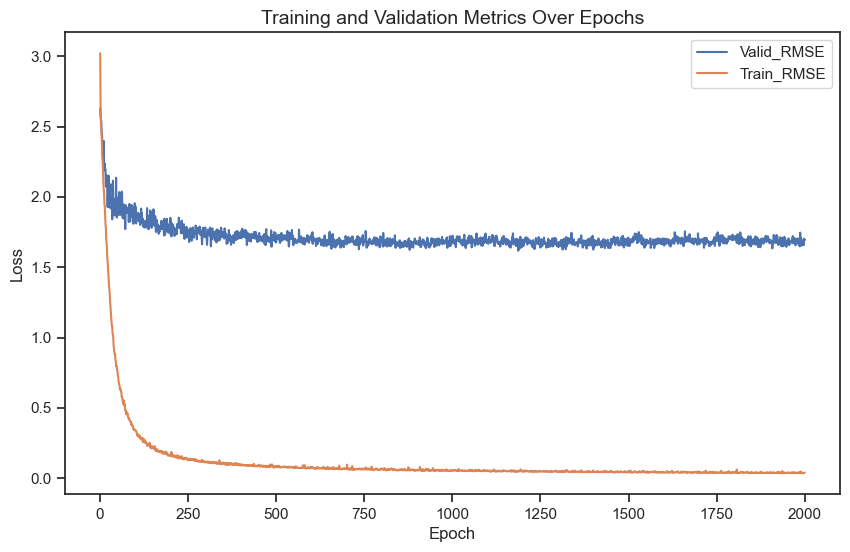

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
# Load metrics

metrics = train_history

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
# sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
# sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
sns.lineplot(data=metrics, x='epoch', y='Val MSE', label='Valid_RMSE')
sns.lineplot(data=metrics, x='epoch', y='Train MSE', label='Train_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()


In [12]:
train_history.tail()

,epoch,Train Loss,Train MSE,Train MAE,Train RMSE,Train R2,Train Pearson,Train Median_AE,Train Explained_VARVal Loss,Val MSE,Val MAE,Val RMSE,Val R2,Val Pearson,Val Median_AE,Val Explained_VAR,Train Explained_VAR,Val Loss
1995,1996,0.036864,0.036864,0.127437,0.127437,0.990564,0.995271,0.092126,NaN,1.695220,0.921327,0.921327,0.575983,0.776300,0.640671,0.577165,0.990564,1.693445
1996,1997,0.035635,0.035632,0.127789,0.127789,0.990879,0.995429,0.092462,NaN,1.657063,0.911629,0.911629,0.585527,0.777496,0.629470,0.586170,0.990879,1.655252
1997,1998,0.037042,0.037042,0.128474,0.128474,0.990519,0.995248,0.092514,NaN,1.696821,0.918274,0.918274,0.575582,0.776311,0.630190,0.576624,0.990519,1.695179
1998,1999,0.036447,0.036451,0.127630,0.127630,0.990670,0.995324,0.092423,NaN,1.702532,0.926897,0.926897,0.574154,0.776669,0.649205,0.577019,0.990670,1.700648
1999,2000,0.039433,0.039434,0.131707,0.131707,0.989906,0.994941,0.095825,NaN,1.693484,0.922117,0.922117,0.576417,0.777954,0.632196,0.576971,0.989907,1.691645


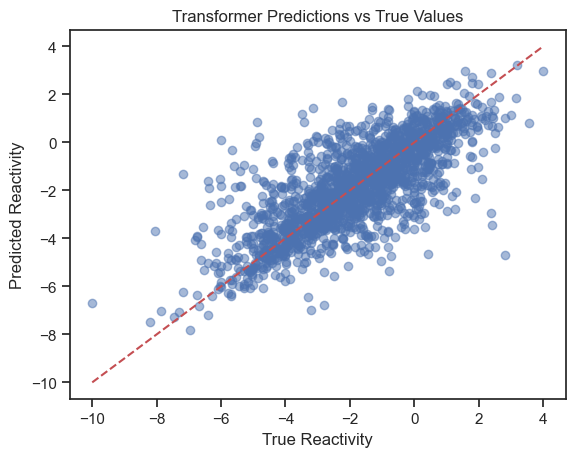

In [13]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("Transformer Predictions vs True Values")
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], 'r--')
plt.show()
